# A tutorial in torchAttacks (Adversarial attacks)
Here I have followed the following [example](https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118) for a convolution neural network.

However I followed this [tutorial](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html) for the adversarial attack stuff.

## Import.STONKS()

And also check whether the GPU is available

In [1]:
from __future__ import print_function
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists
%matplotlib inline

# Path for where we save the model
# this is a magic tool that will come in handy later ;)
saveModelPath = "../trainedModels/adversarial_cifar10_model.pth"

## Important if you want to train again, set this to True
trainAgain = False

## Inputs

We apparently only need two inputs for this attack. They are:

- **Epsilons** A list of epsilon values in the range [0,1]. Importantly 0 has to be kept in the list as it has to represent the model performance on the original test set.
- **use_cuda** Just a boolean to tell the model to use a GPU if available (which it isn't on this computer...)

In [2]:
epsilons = torch.linspace(0, 0.3, 6)
eps_setp_size = epsilons[1].item()


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cpu device


## Downloading data

Downloading a big library of data!

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor()])

batch_size = 4

trainset = datasets.CIFAR10(
    root="../data/datasetCIFAR", train=True, download=True, transform=transform
    )

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )

testset = datasets.CIFAR10(
    root="../data/datasetCIFAR", train=False, download=True, transform=transform
    )

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size,shuffle=False, num_workers=2
    )

classes = ("plane", "car", "bird", "cat",
           "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


## Show some images

Because we have done it so much now. It has just become tradition. We need to see some of dem images!

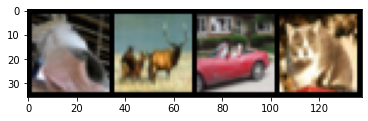

horse deer  car   cat  


In [4]:
# get some random training images
# The "iter( )" function makes an object iterable.
# Meaning that we still can't subscribt it, however we can call the next 
# "instance" (I guess is an apt name), over and over. 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
gridedImages = utils.make_grid(images)
npimg = gridedImages.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

# print labels
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

### Intermediary test

In [5]:
I_Want_Intermediary_Test = False
if I_Want_Intermediary_Test:
    # Finding max of input images
    from math import inf
    maxNum = -inf
    minNum = inf
    for image in images:
        # image = image/2 + 0.5
        tempMax = torch.max(image)
        tempMin = torch.min(image)
        if maxNum < tempMax:
            maxNum = tempMax
        if tempMin < minNum:
            minNum = tempMin

    print(f"Smallest in number in these images: {minNum}\n Greatest number in sample images: {maxNum}")
    

## Model under attack

The model obviously also needs to be defined:

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # I am quite certain that 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the network
model = CNN().to(device)

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Defining loss and optimization function

Both the loss function and the optimization function needs to be defined for this particular neural network.
They are defined as follows.

(Why it is always that CrossEntropyLoss.. I do not know)

In [7]:
lrn_rt = 0.5e-3

loss_fn = nn.CrossEntropyLoss()

# We are just going to use Adam, because it has proven to be effective.
optimizer = optim.Adam(model.parameters(), lr=lrn_rt)

## The Training and Testing Loop

The loops for training and testing:

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    
    for batch, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # Compute prediction and loss
        pred = model(inputs)
        loss = loss_fn(pred, labels)
        
        train_loss += loss.item()
        correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(inputs)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches        
    correct /= size
    return 100*correct, train_loss


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for data in dataloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
        
            pred = model(inputs)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return 100*correct, test_loss

## Training the network

Obviously we also need to fit some weights, so here is the code for training the network.

In [9]:
# exists is a function from os.path (standard library)
trained_model_exists = exists(saveModelPath)

# We train if we haven't already trained
# or we want to train again.
if not trained_model_exists or trainAgain:
    epochs = 8
    accuracies = [[0]*epochs, [0]*epochs]
    losses = [[0]*epochs, [0]*epochs]

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        accuracyTrain, avglossTrain = train_loop(trainloader, model, loss_fn, optimizer)
        accuracyTest, avglossTest = test_loop(testloader, model, loss_fn)
        
        # This is just extra for plotting
        accuracies[0][t] = accuracyTest
        accuracies[1][t] = accuracyTrain
        losses[0][t] = avglossTest
        losses[1][t] = avglossTrain
    print("Done!")
    
else:
    print("Have already trained this model once!")



Have already trained this model once!


### Optional code for plotting
If you wanna see the development of the accuracy and the avg loss, this is the plot for you!

In [10]:
# Only run this if we have trained, so that we have an available plot
if not trained_model_exists or trainAgain:
    xVals = list(range(1, epochs + 1))

    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle(f"Accuracy and loss over {epochs} epochs")

    ax1.plot(xVals, accuracies[0], 'o-', label="Test")
    ax1.plot(xVals, accuracies[1], 'o-', label="Train")
    ax1.legend()
    ax1.set_ylabel("Accuracy over epochs")

    ax2.plot(xVals, losses[0], '.-', label="Test")
    ax2.plot(xVals, losses[1], '.-', label="Train")
    ax2.legend()
    ax2.set_xlabel("epochs")
    ax2.set_ylabel("AVG loss over epochs")
    
    plt.show()
else:
    print("We didn't train, so we can't plot anything...")

We didn't train, so we can't plot anything...


## Saving and loading model

### Saving

Here is quite a good [tutorial](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for saving and loading models.

In [11]:

if not trained_model_exists or trainAgain:
    torch.save(model.state_dict(), saveModelPath)
    print(f"Saved PyTorch Model State to {saveModelPath}")

### Load
Loading the model afterwards... quite an important part of the process.

In [12]:
model = CNN().to(device)
model.load_state_dict(torch.load(saveModelPath))

<All keys matched successfully>

## FGSM Attack
(Fast Gradient Sign Method) Attack.
Here we define the function that creates the adversarial example by urbing the original image.

In [35]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    print("Shape of sign data grad", sign_data_grad.size())
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

## Testing function
This is a testing function written by the peeps at pyTorch. It seems like it does a lot, I am not entirely sure what everything is though.

In [36]:
def test(model, device, test_loader, epsilon, someSeed):
    # Manxi's superior testing function

    # Accuracy counter
    # correct = 0
    adv_examples = []
    adv_imgs = []
    adv_pred_labels = []
    adv_attack_labels = []
    pred = []
    gt = []
    
    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        _, init_pred_index = output.max(1, keepdim=True) # get the index of the max log-probability
    
        idx = (init_pred_index.flatten() == target.flatten()) # B, bool 
        
        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data
        
        # NOTE: I put the indexing after the back propagation, 
        # so that "data" appears on the computation graph 
        # (which is used for computing the gradient)
        
        data_grad = data_grad[idx, ...]
        if not data_grad.size(0):
            continue        
        
        data = data[idx, ...]
        output = output[idx, ...] # N, C
        target = target[idx] # N
        init_pred_index = init_pred_index[idx, ...]

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True) # get the index of the max log-probability
        
        final_pred_index = final_pred[1]
        
        adv_ex = perturbed_data.detach()
        adv_imgs.append(adv_ex)
        adv_pred_labels.append(init_pred_index.detach())
        adv_attack_labels.append(final_pred_index.detach())

        pred.append(final_pred_index.flatten().detach().cpu().numpy())
        gt.append(init_pred_index.flatten().detach().cpu().numpy())
        
    # Calculate final accuracy for this epsilon
    #final_acc = correct/float(len(test_loader)) # This is for computing the accuracy over batches
    # We usually compute the accuracy over instances
    pred = np.concatenate(pred, axis=0)
    gt = np.concatenate(gt, axis=0)
    correct = np.sum(pred == gt)
    final_acc = correct / len(gt)
    
    # np.random.seed(0) # if you would like to make the result repeatable, you should fix the random seed    
    np.random.seed(someSeed)
    adv_imgs = torch.cat(adv_imgs, dim=0).cpu().numpy()
    num_random_imgs = 5
    
    img_num = adv_imgs.shape[0]
    rndm_imgs_ID = np.arange(img_num)
    np.random.shuffle(rndm_imgs_ID)
    rndm_imgs_ID = rndm_imgs_ID[:num_random_imgs] # now we randomly pick 5 indices
        
    adv_imgs = adv_imgs[rndm_imgs_ID, ...]
    adv_pred_labels = torch.cat(adv_pred_labels, dim=0).cpu().numpy()[rndm_imgs_ID, ...]
    adv_attack_labels = torch.cat(adv_attack_labels, dim=0).cpu().numpy()[rndm_imgs_ID, ...]
    
    adv_examples = [(adv_pred_labels[i, ...][0], adv_attack_labels[i, ...][0], adv_imgs[i, ...]) for i in range(num_random_imgs)]     
    
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(round(epsilon.item(), 3), correct, len(gt), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

## Finally we run the attack
This also saves some values, so that we can see how the accuracy falls along with greater epsilon (error) rates.


In [37]:
accuracies = []
examples = []
someSeed = np.random.randint(low=0, high=2**30)        
        
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, testloader, eps, someSeed)
    accuracies.append(acc)
    examples.append(ex)

Shape of sign data grad torch.Size([2, 3, 32, 32])
perturbed data size: torch.Size([2, 3, 32, 32])
adv_example size: torch.Size([2, 3, 32, 32])
Shape of sign data grad torch.Size([3, 3, 32, 32])
perturbed data size: torch.Size([3, 3, 32, 32])
adv_example size: torch.Size([3, 3, 32, 32])
Shape of sign data grad torch.Size([3, 3, 32, 32])
perturbed data size: torch.Size([3, 3, 32, 32])
adv_example size: torch.Size([3, 3, 32, 32])
Shape of sign data grad torch.Size([2, 3, 32, 32])
perturbed data size: torch.Size([2, 3, 32, 32])
adv_example size: torch.Size([2, 3, 32, 32])
Shape of sign data grad torch.Size([3, 3, 32, 32])
perturbed data size: torch.Size([3, 3, 32, 32])
adv_example size: torch.Size([3, 3, 32, 32])
Shape of sign data grad torch.Size([3, 3, 32, 32])
perturbed data size: torch.Size([3, 3, 32, 32])
adv_example size: torch.Size([3, 3, 32, 32])
Shape of sign data grad torch.Size([1, 3, 32, 32])
perturbed data size: torch.Size([1, 3, 32, 32])
adv_example size: torch.Size([1, 3, 3

KeyboardInterrupt: 

## Results
We make an **accuracy** vs. **epsilon*** plot and see that there is a clear correlation.

### Accuracy vs. Epsilon

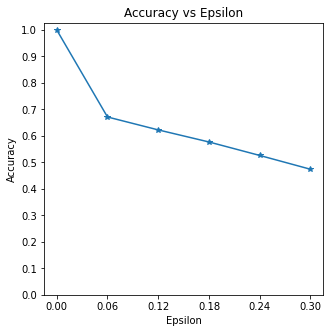

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, torch.max(epsilons)+eps_setp_size, step=eps_setp_size))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

### Sample Adversarial Examples
Here we show some of the images that are the results of adversarial attacks, alongside the prediction by the network :) 

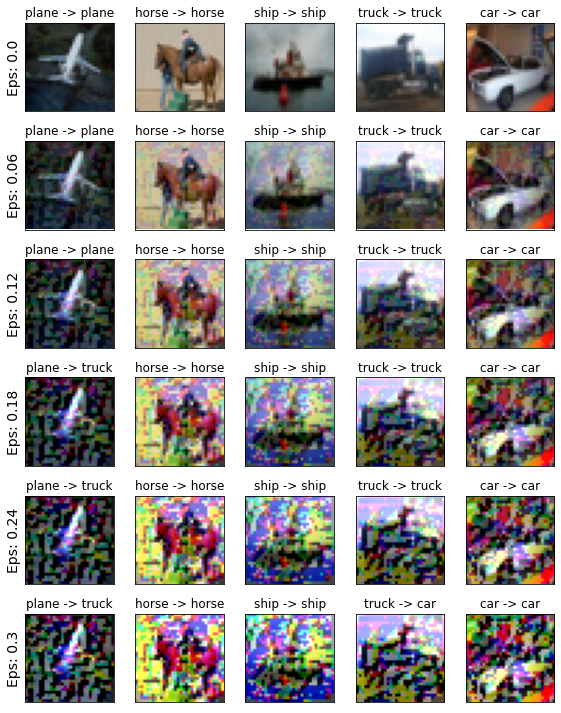

In [ ]:
# Plot several examples of adversarial samples at each epsilon

cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(round(epsilons[i].item(), 3)), fontsize=14)
        orig,adv,ex = examples[i][j]
        
        # CIFAR is complicated so we need to reshape and normalize..
        reshaped_ex = np.transpose(ex, (1, 2, 0))
        #print(f"min: {min(reshaped_ex.flatten())}")
        #normalised_ex = reshaped_ex / 2     # unnormalize
        #print(f"max: {max(reshaped_ex.flatten())}")
        
        plt.title("{} -> {}".format(classes[orig], classes[adv]))
        plt.imshow(reshaped_ex)
plt.tight_layout()
plt.show()